In [ ]:
# default_exp core

In [ ]:
#hide
from nbdev.showdoc import *

# Fastai segmentation tile

> API details.

In [ ]:
from fastai.vision.all import *
from dataclasses import dataclass, astuple
from typing import Tuple, Collection
from collections import namedtuple
from functools import lru_cache
from itertools import product

In [ ]:
def get_image_tile(img: Image, idx, tile_sz) -> Image:
    row, col = idx
    tile_y, tile_x = tile_sz
    # need to use .px instead of .data because ImageSegment convert data to int64
    return Image(img.px[:, row * tile_y:(row + 1) * tile_y, col * tile_x:(col + 1) * tile_x])


def open_image_tile(img_t: ImageTile, **kwargs) -> Image:
    """given and ImageTile it returns and Image with the tile,
    set mask to True for masks"""
    path, idx, tile, scale, bg, mask_t = img_t
    img = open_image_cached(path, scale=scale, **kwargs)
    img = get_image_tile(img, idx, tile)

    if bg:
        mask = open_mask_tile(mask_t)
        img = bg.apply(img, mask)
    return img


def open_mask_tile(mask_t: ImageSegmentTile, **kwargs):
    path, idx, tile, scale = mask_t
    img = open_mask_cached(path, scale=scale, **kwargs)
    return ImageSegment(get_image_tile(img, idx, tile).px)


def get_tiles(images, rows: int, cols: int, tile_info: Collection) -> Collection[ImageTile]:
    images_tiles = []
    for img in images:
        for row, col in product(range(rows), range(cols)):
            images_tiles.append(ImageTile(img, (row, col), *tile_info))
    return images_tiles

NameError: name 'ImageTile' is not defined

In [ ]:
@dataclass(repr=True)
class ImageTile:
    path: Path
    idx: namedtuple("tile_index", "row col")
    tile_sz: namedtuple("tile_size", "width height")
    def __iter__(self):
        yield from astuple(self)

In [ ]:
def image_tile(img: PILImage, idx, tile_sz) -> Image:
    row, col = idx
    tile_width, tile_height = tile_sz
    # maybe be not 100% efficient as convert back and forth between pytorch and np array
    img = tensor(img) # Needed to access the underlying data - this it seems is in the format height, width, channels
   
    return PILImage.create(img[row * tile_height:(row + 1) * tile_height, col * tile_width:(col + 1) * tile_width,:])

In [ ]:
def get_image_tiles(image_paths, rows: int, cols: int, tile_info: Collection) -> Collection[ImageTile]:
    """given a list of files returns a list of all the possible image tiles"""
    image_tiles = L()
    for path in image_paths:
        for row, col in product(range(rows), range(cols)):
            image_tiles.append(ImageTile(path, (row, col), *tile_info))
    return image_tiles

In [ ]:
def open_image_tile(img_t: ImageTile) -> PILImage:
    """given and ImageTile it returns and Image with the tile,
    set mask to True for masks"""
    path, idx, tile_sz = img_t
    img = open_image_cached(path)
    img = image_tile(img, idx, tile_sz)
    
    return img

@lru_cache()
def open_image_cached(path) -> PILImage:
    return PILImage.create(path)


In [ ]:
class ImageTileTransform(Transform):
    def __init__(self, files, n_rows, n_cols, tile_sz):
        self.image_tiles = get_image_tiles(files, n_rows, n_cols, (tile_sz,))
        store_attr(but="files")
    def encodes(self, i):
        return open_image_tile(self.image_tiles[i])

In [ ]:
#for testing purposes
files = get_image_files("dataset_segmentation/images")

In [ ]:
files

(#129) [Path('dataset_segmentation/images/Banana4.png'),Path('dataset_segmentation/images/Carrot4.png'),Path('dataset_segmentation/images/Peach4.png'),Path('dataset_segmentation/images/Apple2.png'),Path('dataset_segmentation/images/Apple9.png'),Path('dataset_segmentation/images/Potato6.png'),Path('dataset_segmentation/images/Lime2.png'),Path('dataset_segmentation/images/Pear11.png'),Path('dataset_segmentation/images/Plum5.png'),Path('dataset_segmentation/images/Apricot6.png')...]

In [ ]:
PILImage.create(files[0]).size

(2466, 3498)

In [ ]:
test_pipeline = TfmdLists(range(len(files*2*3)), ImageTileTransform(files, 2, 3, (1233, 1166)))

In [ ]:
dls = test_pipeline.dataloaders()

Could not do one pass in your dataloader, there is something wrong in it


In [ ]:
dls = DataLoaders.from_dsets(test_pipeline)

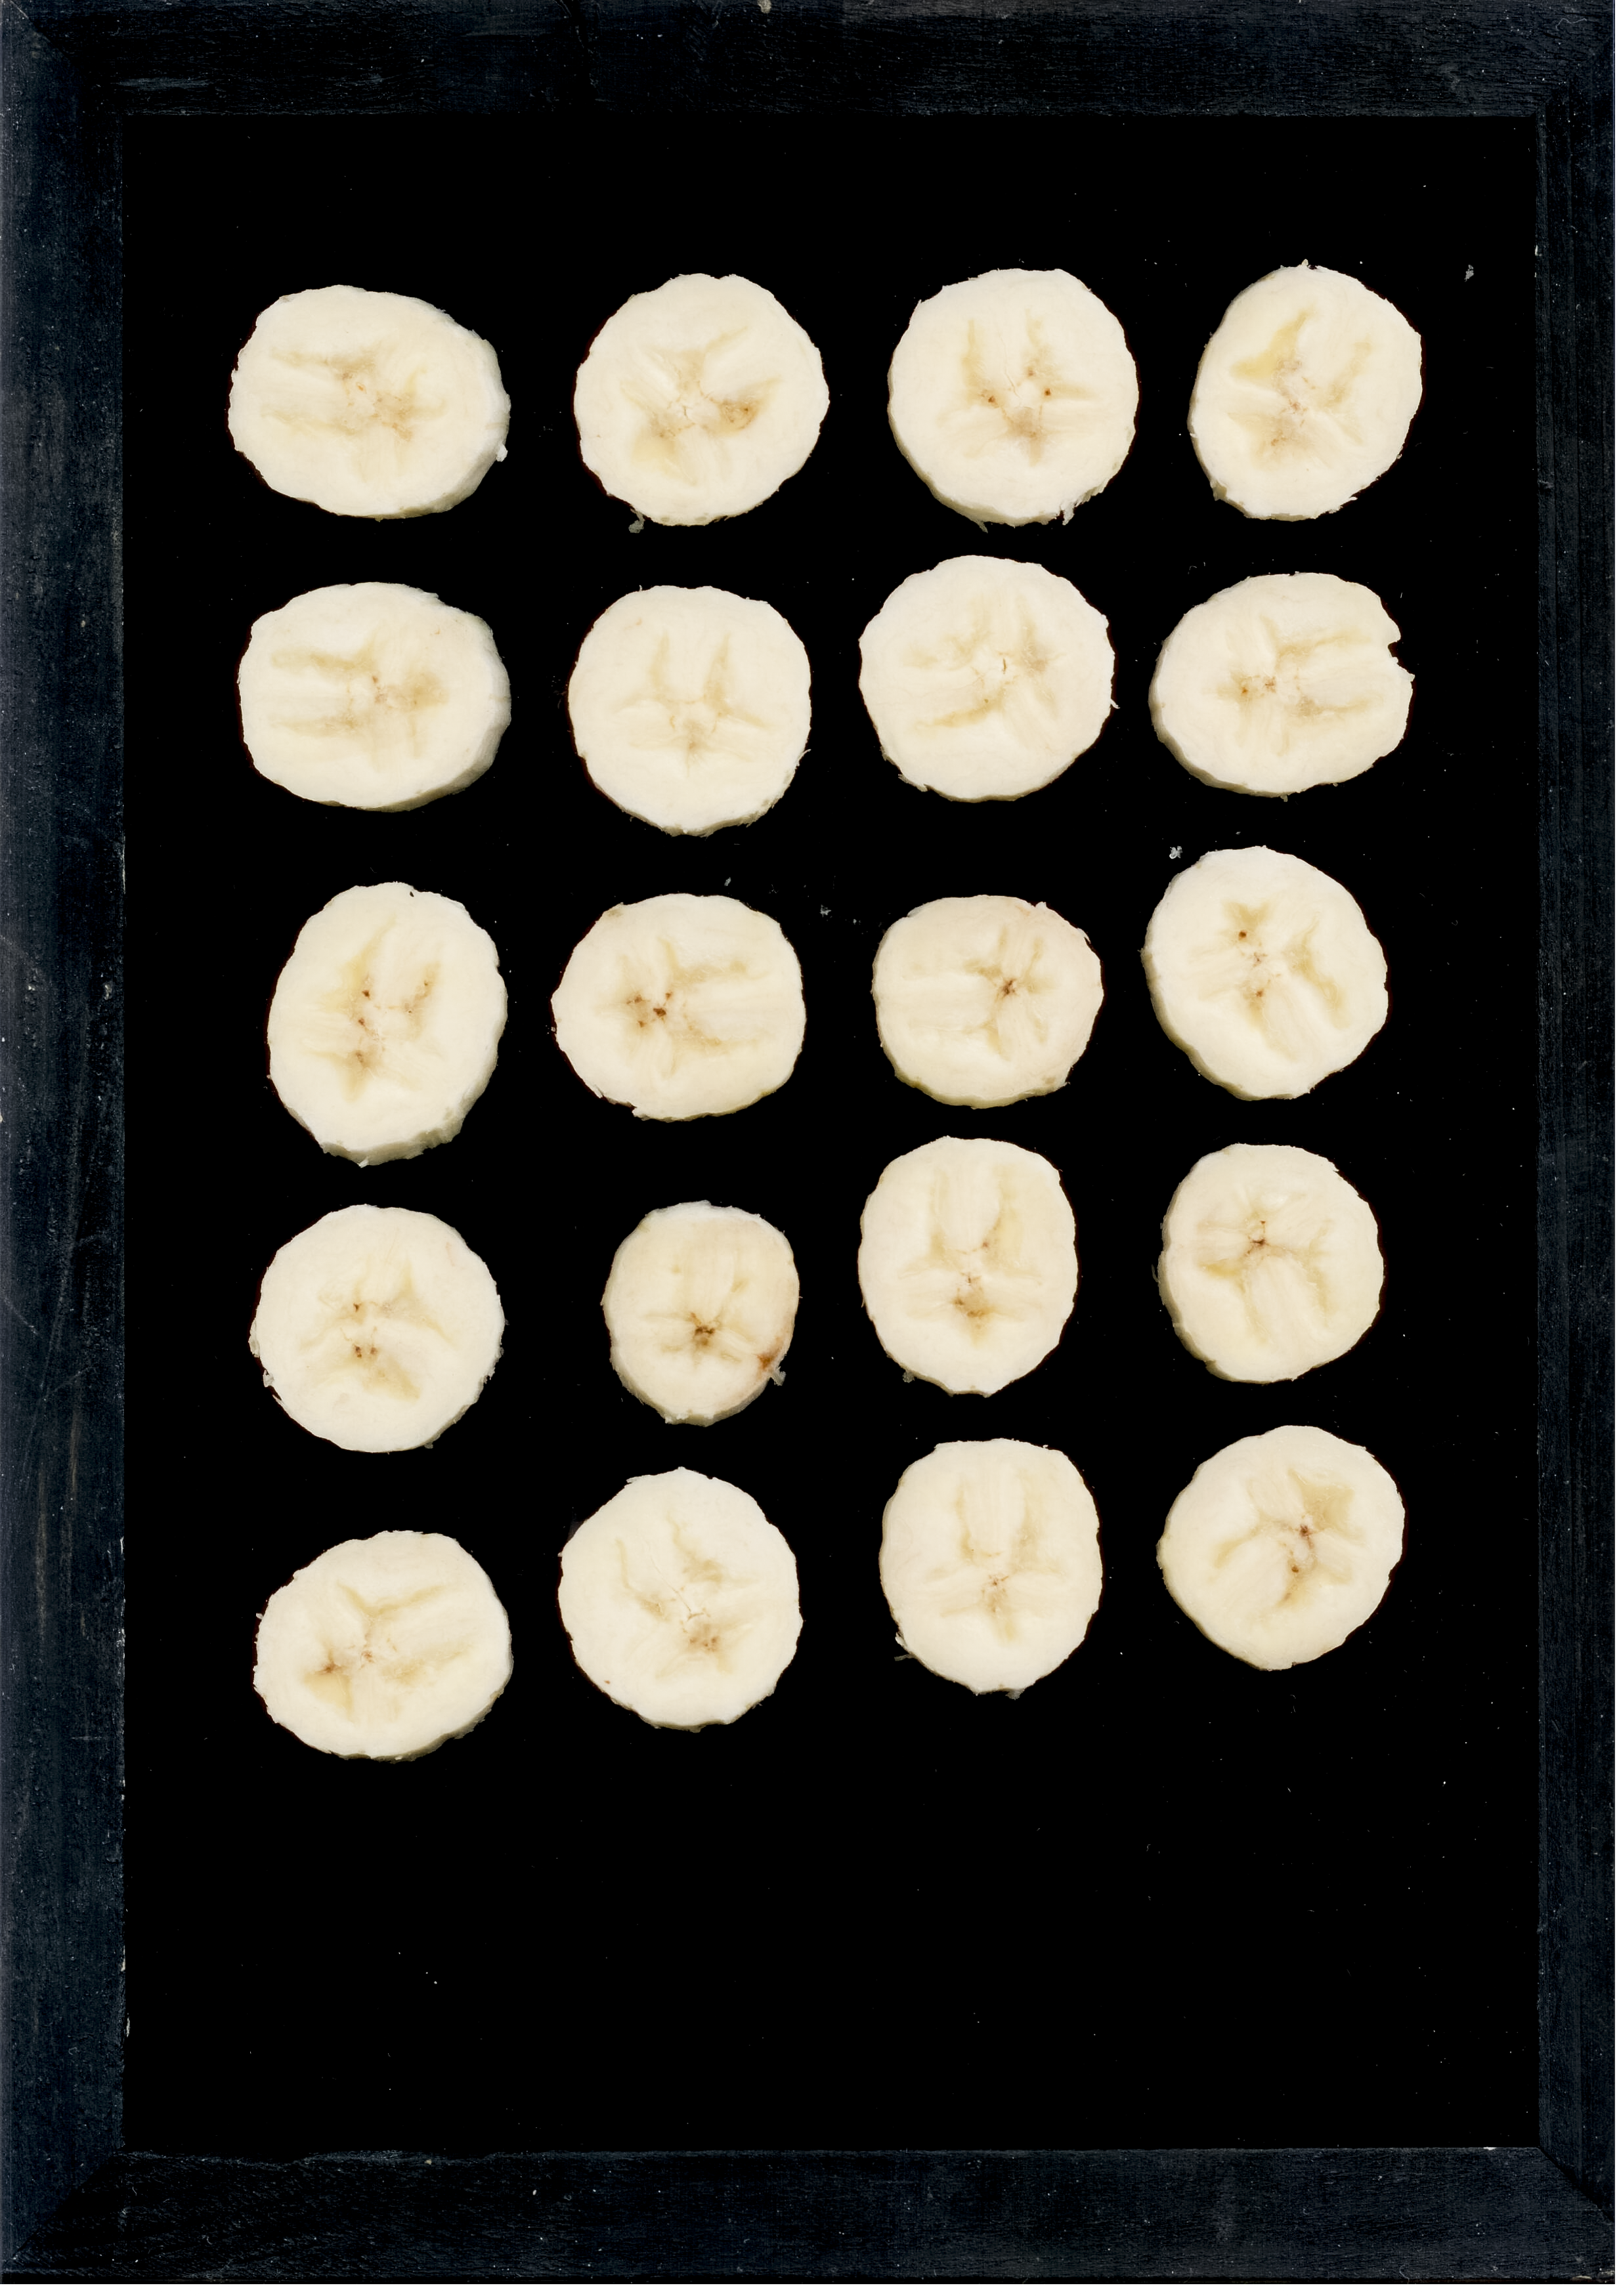

In [ ]:
PILImage.create(files[0])

(<AxesSubplot:>, <AxesSubplot:>)

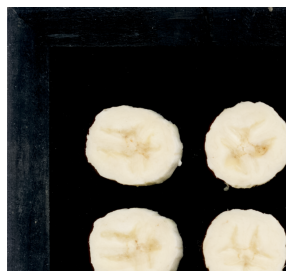

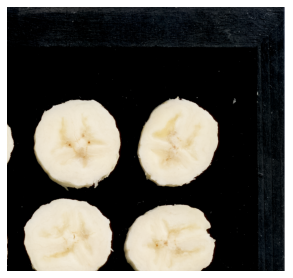

In [ ]:
test_pipeline[0].show(), test_pipeline[1].show()

In [ ]:
test_pipeline[0].size

(1233, 1166)

In [ ]:
for i in range(len(files)*2*3):
    assert test_pipeline[1].size, (1233, 1166)